In [53]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Programming a fully-connected neural network from scratch

by Johannes Bock

In the following notebook I will implement a two-layer fully-connected neural network from scratch only using NumPy, the fundamental package for scientific computing with Python. Moreover, I will implement a few different variants of the most important network hyperparameters relating to activation functions, optimizers, weight initialization and regularization. I will also discuss and show their advantages and disadvantages.

Even though I will not implement sequence models (Recurrent neural networks) or Convolutional neural networks from scratch in this notebook, the following discussion of hyperparameter variants also applies and even in particular applies to these network architectures. 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")

rnd_state = 19
np.random.seed(rnd_state)

## Marketing dataset

In order to test my neural network implementation I decided to use a real-world dataset. The [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from the UCI Machine Learning repository seemed to be a perfect choice. It contains data that is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls, where clients were offered a new product (bank term deposit). Based on the personal data on the clients and their respective response to the new product offer ('yes' or 'no'), the task is to train a model that predicts whether or not a client is likely to subscribe to the new product or not. 

In [2]:
import pandas as pd

#import the data
dat = pd.read_csv("data/bank-additional-full.csv",delimiter=";")
dat = dat.sample(frac=1,random_state=rnd_state).reset_index(drop=True) #shuffle dataframe
print 'There are %d samples and %d variables including the label in the data set' % (
                dat.shape[0],dat.shape[1])
dat.head()

There are 41188 samples and 21 variables including the label in the data set


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,62,management,married,university.degree,no,yes,yes,cellular,aug,wed,...,2,999,0,nonexistent,-2.9,92.201,-31.4,0.879,5076.2,no
1,33,services,married,basic.9y,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
2,38,technician,single,university.degree,no,yes,yes,cellular,may,wed,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.334,5099.1,yes
3,41,services,married,high.school,unknown,yes,yes,telephone,may,mon,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,36,admin.,married,university.degree,no,no,no,cellular,oct,thu,...,2,999,1,failure,-3.4,92.431,-26.9,0.722,5017.5,no


In [3]:
perc = dat["y"].value_counts()/dat.shape[0] #Strongly imbalanced dataset
print 'About %d percent of the customers decided to subscribe to the new product.' % (
                round(perc["yes"]*100,0))

About 11 percent of the customers decided to subscribe to the new product.


In [4]:
#Get only the categorical feature names in order to transform them
cat_features = list(dat.select_dtypes(include=['object']).copy().columns)
cat_features.remove("y")

#Get only the numeric and int feature names in order to scale them
num_features = list(dat.select_dtypes(include=['int64',"float64"]).copy().columns)

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# One-hot encode all categorical features
dv = DictVectorizer(sparse=False) # Initialize OneHotEncoder

cat_dat = dat.loc[:,cat_features]
onehot_cat = pd.DataFrame(dv.fit_transform(cat_dat.to_dict(orient='records')),columns = dv.feature_names_,
                           index = cat_dat.index) # Fit the onehot encoder to the training data

# Scale all numeric features between 0 and 1
scaler = MinMaxScaler()

num_dat = dat.loc[:,num_features]
scaled_dat = pd.DataFrame(scaler.fit_transform(num_dat),columns = num_dat.columns,
                           index = num_dat.index)

#Join all feature 
X = scaled_dat.join(onehot_cat)
y = dat.loc[:,"y"].astype("category").cat.codes
X = X.as_matrix()
y = y.as_matrix()
 
# Get simple training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rnd_state)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=rnd_state)

n_features = X_train.shape[1]
n_classes = 2

To validate the model, the data is being split into a training and validation set (10% of the data). The final model is evaluated using a test set (10% of the data). Moreover, the categorical features are being one-hot encoded and the numerical features scaled between 0 and 1.

In [6]:
import warnings
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings("ignore")

#Under-sampling the majority class.
rus = RandomUnderSampler(ratio=.5, return_indices=True,random_state = rnd_state)

_, __, idx_resampled = rus.fit_sample(X_train, y_train)
X_resampled = X_train[idx_resampled,]
y_resampled = y_train[idx_resampled,]

_, __, idx_resampled = rus.fit_sample(X_val, y_val)
X_val = X_val[idx_resampled,]
y_val = y_val[idx_resampled,]

print "Total sample size:",y_resampled.shape[0]
print "Class_1 share in training sample:",np.bincount(y_resampled.astype(int))[1]*100/y_resampled.shape[0],"%"

Total sample size: 11154
Class_1 share in training sample: 33 %


Since the target class is fairly unbalanced, Undersampling of the majority class is used in order to enable the model to also learn patterns related to the positive class. The validation set will have the same distribution as the training set, however, the test set will have the original distribution of the target class in order to assess the classifier's performance. The model is trained on 11,154 samples and contains 33% of class 1 customers (= customers who subscribed to the new product).

In [7]:
# One-hot encode target var
y_resampled = np.eye(2)[y_resampled]
y_val = np.eye(2)[y_val]
y_test = np.eye(2)[y_test]

## Activation functions

In order to learn complex non-linear relationships with my neural network, I will first implement non-linear activation functions, which I can later use in my network. These functions will be applied to each layer in the network. More precisely they will be applied to the dot product of an input matrix $X$ and a weight matrix $W$. Since I will later need to compute the gradients of these functions with respect to their inputs, I also implement convenient methods for these.

#### Sigmoid

The most traditional activation function is the sigmoid function.

$\sigma(x)= \frac{1}{1+e^{-x}}$

$\sigma^{'}(x)= \frac{d\sigma}{dx} = \sigma(x)(1-\sigma(x))$

In [8]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input

    Arguments:
    x -- numpy array.

    Return:
    s -- sigmoid(x)
    """

    return 1/(1+np.exp(-1*x))


def sigmoid_grad(s):
    """
    Compute the gradient for the sigmoid function.

    Arguments:
    s -- numpy array. sigmoid function value of original input X

    Return:
    ds -- Your computed gradient.
    """

    return s*(np.ones(s.shape)-s)

#### Rectified Linear Unit (ReLu)

Recently, more often used is the rectified linear unit, since it has proven to be more promising in terms of quicker convergence. However, a careful weight initialization needs to be chosen, when using ReLu layers (See later).

$ ReLu(x) = max(0,x) $

$\frac{d ReLu}{d x} = \begin{cases}
       \text{1,} &\quad\text{x} > 0\\
       \text{0,} &\quad\text{x}\le0\\
     \end{cases}$

In [9]:
def relu(x):
    """
    Compute the ReLu function for the input

    Arguments:
    x -- numpy array.

    Return:
    r -- relu(x)
    """

    return np.maximum(0,x)

In [10]:
def relu_grad(r):
    """
    Compute the gradient for the ReLu function.

    Arguments:
    r -- numpy array. ReLu function value of original input X

    Return:
    dr -- Your computed gradient.
    """
    dr = np.ones(r.shape)
    dr[r<=0] = 0
    return dr

#### Tanh

Sometimes a tanh activation function is used. However, it is not as common as the sigmoid or relu function above.

$\tanh(x) = \frac{1−e^{−2x}}{1+e^{−2x}} $

$\tanh^{'}(x)= \frac{d\tanh}{dx} = 1-\tanh^{2}(x)$

In [11]:
def tanh(x):
    """
    Compute the tanh function for the input

    Arguments:
    x -- numpy array.

    Return:
    r -- tanh(x)
    """
    return np.tanh(x)

In [12]:
def tanh_grad(t):
    """
    Compute the gradient for the tanh function.

    Arguments:
    t -- numpy array. tanh function value of original input X

    Return:
    dt -- Your computed gradient.
    """
    
    return 1-t^2

#### Softmax

In order to being able to interpret the output of the neural network as probabilities in a classification setting, a softmax function is being implemented. The softmax function squashes the activations of the last layer of a network into a probability distribution.

$ softmax(x)_j = \frac{e^{x_j}}{\sum_{k=1}^K e^{x_k}} \quad \textrm{for j = 1,..., K} \\
\\ 
\quad \textrm{where K is the number of classes} $

In [13]:
def softmax(x):
    """Compute the softmax function for each row of the input x.

    Arguments:
    x -- A N dimensional vector or M x N dimensional numpy matrix.

    Return:
    s -- softmax(x)
    """

    if len(x.shape) > 1:
        # Matrix
        x = x - np.max(x,axis=1).reshape((x.shape[0],-1))
        x = (np.exp(x).T/np.exp(x).sum(axis = 1)).T
       
    else:
        # Vector
        x = np.exp(x)/np.exp(x).sum()

    return x

## Forward- and Backpropagation

In this section the basic neural network architecture, cost function and backpropagation algorithm will be implemented for a classification problem. I will build a 2-layer neural network consisting of an input layer, one hidden layer with some non-linear activation function and a softmax output layer as shown in the graphic below.

<img src="https://i.imgur.com/jXmajdl.png" alt="Drawing" style="width: 400px;"/>

### Forward pass

The forward pass will transform the inputs $X$ into $\hat{y}$. For this particular network the forward pass can be expressed as follows:

$ z_1 = xW_1+b_1\\
z_2 = hW_2 +b_2\\
h = \sigma{(z_1)}\\
\hat{y} = softmax(z_2) \\
\quad \\
\text{where} \quad W_1,W_2,b_1,b_2 \quad \text{are the learnable network parameters.}$

### Cost function

In order to optimize the network parameters $\theta$ with respect to a loss function, we first need to define a loss. A widely used loss function for classification problems is the cross entropy loss, which is defined as follows:

$ J(\theta) = -\sum_{i} y_i \log(\hat{y}_i)\\
\quad \\
\text{where} \quad y \quad \text{is the one-hot label vector, and}\quad \hat{y} \quad \text{is the predicted probability vector for all classes}$

### Backpropagation

After having defined the loss, we can now compute the gradients of the network parameters with respect to the loss function. The backpropagation algorithm will "backpropagate" the partial derivatives through the network using the chain rule in order to find $\frac{\partial J}{\partial W_1}, \frac{\partial J}{\partial W_2},\frac{\partial J}{\partial b_1}, \frac{\partial J}{\partial b_2}$. The following graphic shows the basic idea of the following calculations (Note that $L=J$):  

<img src="https://github.com/bockjo/deeplearning-and-related/raw/master/Backprop.png" alt="Drawing" style="width: 500px;"/>

$ \frac{\partial J}{\partial W_2}  = \frac{\partial J}{\partial z_2} \frac{\partial z_2}{\partial W_2}= h^T(\hat{y}-y)\\
   \frac{\partial J}{\partial W_1} = \frac{\partial J}{\partial z_2} \frac{\partial z_2}{\partial h} \frac{\partial h}{\partial z_1} \frac{\partial z_1}{\partial W_1} = x^T((\hat{y}-y)W_2^T\sigma^{'}(z_1))\\
$

In [14]:
def loss(data, params, dimensions,labels=None, act_func ="relu",mode = "train", weight_decay = False, reg_lambda=0.001,
        dropout = False, p = 0.5, seed = None):
    """
    Forward and backward propagation for a two-layer network

    Arguments:
    data -- M x Dx matrix, where each row is a training example.
    labels -- M x Dy matrix, where each row is a one-hot vector.
    params -- Model parameters/ model weights
    dimensions -- A tuple of input dimension, number of hidden units
                  and output dimension
    act_func -- A string defining the activation function for the hidden layer
    mode -- A string either "train" or "test" determining the mode
    weight_decay -- a function object (either L1 or L2) defining the weight decay scheme
    reg_lambda -- a float number setting the L1 or L2 hyperparameter
    dropout -- Boolean determining if dropout is performed or not
    p -- a float between 0 and 1 determining the dropout probability
    seed -- an integer setting the random state (only needed for gradient checking)
    
    Outputs:
            - cost: Cross-entropy cost.
            - grad: Gradients of all parameters.
    """
    
    activations = {"sigmoid":(sigmoid,sigmoid_grad), "relu":(relu,relu_grad), "tanh":(tanh,tanh_grad)}
    act = activations[act_func][0]
    act_derivative = activations[act_func][1]
    N = data.shape[0]
    
    ### Unpack network parameters
    ofs = 0
    Dx, H, Dy = (dimensions[0], dimensions[1], dimensions[2])
    
    W1 = np.reshape(params[ofs:ofs+Dx*H], (Dx, H)) # Dx * H
    ofs += Dx * H
    b1 = np.reshape(params[ofs:ofs+H], (1, H))
    ofs += H
    W2 = np.reshape(params[ofs:ofs+H*Dy], (H, Dy)) # H * Dy
    ofs += H * Dy
    b2 = np.reshape(params[ofs:ofs+Dy], (1, Dy))

    #forward propagation
    z1 = np.matmul(data,W1)+b1
    h = act(z1)
    
    #Peform Dropout if required
    if dropout and mode == "train":
        h,cache = dropout_forward(h, p, mode, seed = seed)
        
    z2 = np.matmul(h,W2)+b2
    out = softmax(z2)
    
    #At test time only return the scores
    if mode == "test":
        return out,W1, b1, W2, b2 
    
    # Compute the un-normalized cross entropy cost
    cost = -np.sum((labels * np.log(out)).sum(axis=1))
    
    #backward propagation
    d1 = (out - labels) # dcost/dz2
    gradW2 = np.matmul(h.T,d1) #dz2/dw2
    gradb2 = np.sum(d1, 0, keepdims=True) # 1 * Dy
    dhidden = np.dot(d1, W2.T) * act_derivative(h) # dcost/dz2 * dz2/dh * dh/dz1
    
    #If dropout in forward pass, scale gradients according to inverted dropout cache
    if dropout:
        dhidden = dropout_backward(dhidden, cache)
        
    gradW1 = np.matmul(data.T,dhidden) #dhidden * dz1/dw1
    gradb1 = np.sum(dhidden, 0, keepdims=True)
    
    ### Stack gradients
    grad = np.concatenate((gradW1.flatten(), gradb1.flatten(),
        gradW2.flatten(), gradb2.flatten()))
    
    if weight_decay:
        reg_cost, reg_grad = weight_decay(reg_lambda, W1, b1, W2, b2)
        return cost + reg_cost, grad + reg_grad
    
    return cost, grad

### Weight initialization

#### Random initialization

In order to have a starting point we need to initialize the network parameters/ weights randomly. It is crucial to initialize the weights wisely as otherwise the network might never converge to a local minimum and hence, will note solve the classification problem at hand. A number of research papers have been published on this issue and it turns out that depending on the choice of activation functions initialization schemes after either [Glorot et al., 2010](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) or [He et al., 2015](https://arxiv.org/pdf/1502.01852.pdf) are very popular and a good starting point.

In [15]:
def init_scheme(fan_in,scheme):
    if scheme == "Normal": return 1.
    if scheme == "Small_Normal": return 100.
    if scheme == "Xavier": return np.sqrt(fan_in)
    if scheme == "He":
        if fan_in<2: 
            return 1.
        else: 
            return np.sqrt(fan_in/2)


def init_weights(dimensions,scheme = "Xavier",seed = None):
    """
        Randomly initialize network parameter.
        Inputs:
        - dimensions: the network architecture
        - scheme: The init scheme to be used
        - seed: Random state for reproducability.
        Returns:
        - init_weights: Randomly initialized weights
        """
    
    if seed: np.random.seed(seed) #Set seed
    
    Dx, H, Dy = (dimensions[0], dimensions[1], dimensions[2])
    
    #layer initialization after Glorot et al., 2010 (Xavier init)
    W1 = np.random.randn(Dx,H)/init_scheme(Dx,scheme)
    b1 = np.random.randn(1,H)/init_scheme(1,scheme)
    W2 = np.random.randn(H,Dy)/init_scheme(H,scheme)
    b2 = np.random.randn(1,Dy)/init_scheme(1,scheme)
    
    ### Stack gradients
    init_weights = np.concatenate((W1.flatten(), b1.flatten(),
        W2.flatten(), b2.flatten()))
    
    return init_weights

##### Activations and init schemes

Especially when dealing with multi-layer neural networks (deep nets) it is crucial to randomly initialize the parameters correctly. According to [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) the missing initialization schemes in the 70's were one reason among others why neural networks lost their attractivity back then. 

The following demonstration of different initialization schemes adopted from [Stanford's deep learning course CS231n by Andrej Karpathy](https://youtu.be/gYpoJMlgyXA?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC&t=2217) will show some evidence for the importance of choosing the right initialization. 

In the graphs below you can see the distributions of the neuron's activations for each layer of a simple neural network with 10 layers and 500 units each during the forward pass given a specific hidden activation function and initialization scheme.

tanh & Small_Normal



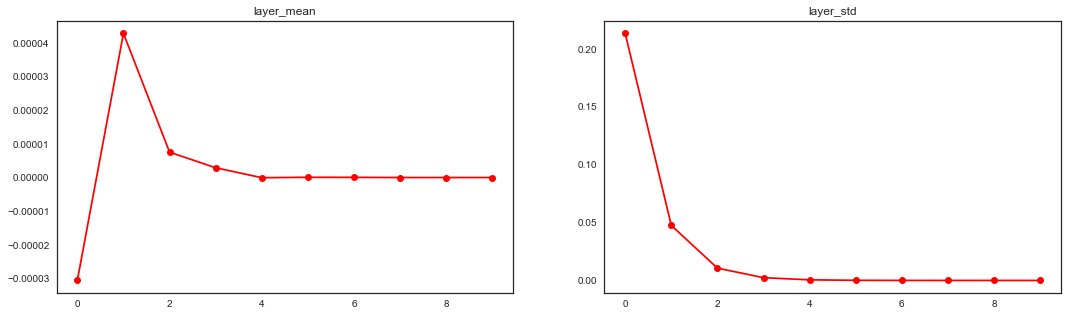

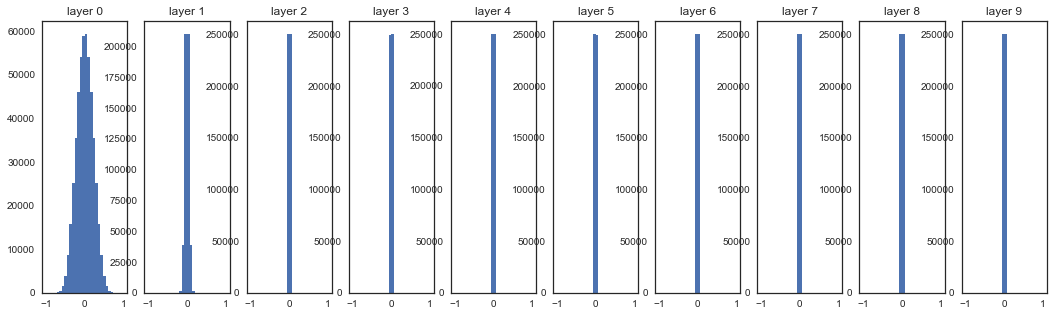

In [16]:
import utils
from utils import *; reload(utils)

figure = layer_weights("tanh", "Small_Normal")
figure.show()

When using a simple random normal distribution with zero mean and 0.01 standard deviation for initializing the network layers, one can quickly see that the networks's activations using tanh vanish after 3 layers.

sigmoid & Normal



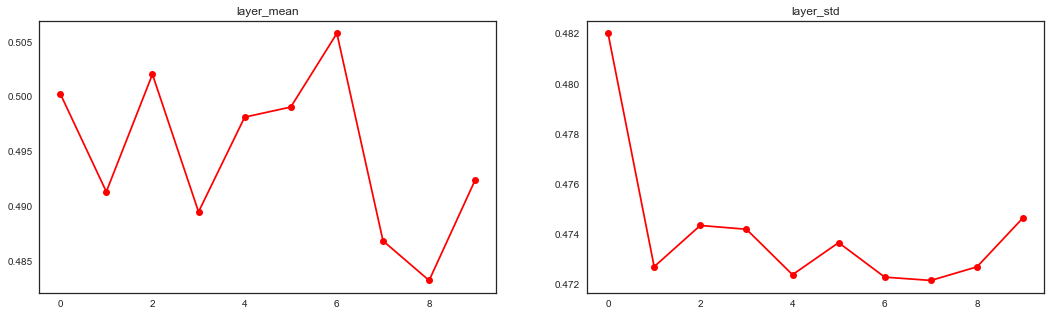

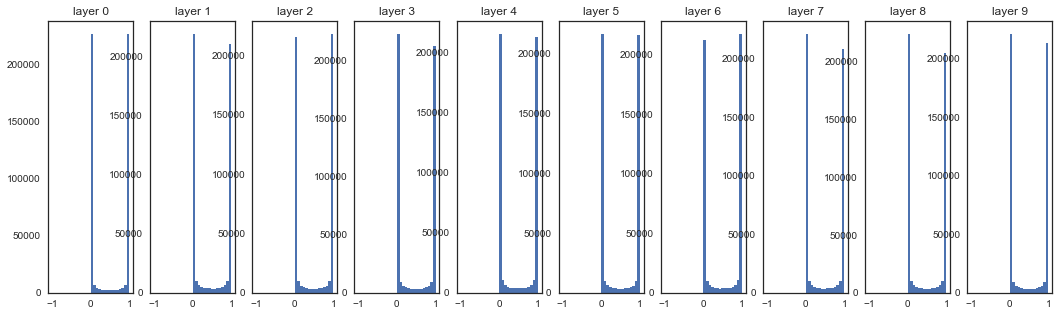

In [17]:
figure = layer_weights("sigmoid", "Normal")
figure.show()

When using a simple random normal distribution with zero mean and 1.0 standard deviation for initializing the network layers and sigmoid activations, one can quickly see that almost all neurons saturated to either 0 or 1. Therefore, most gradients will be zero and network will not be able to "learn".

tanh & Xavier



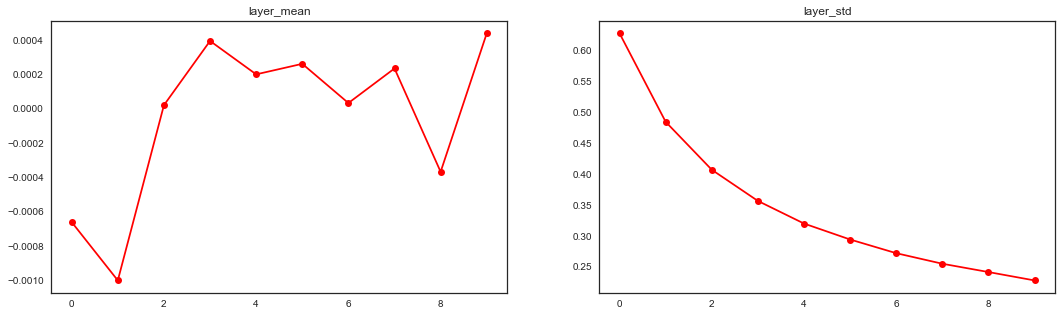

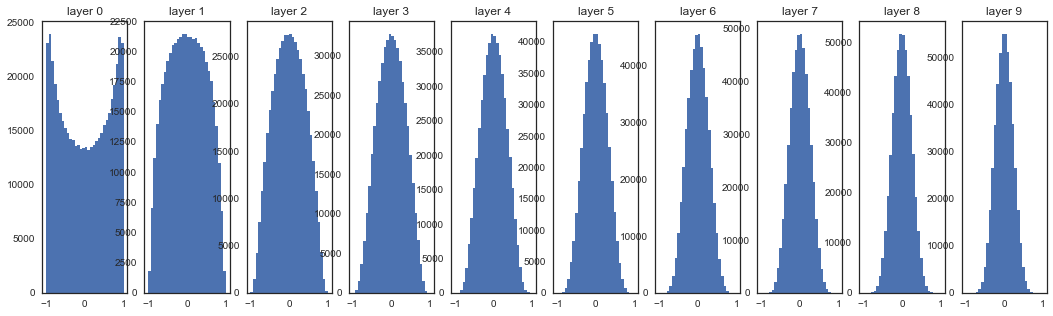

In [18]:
figure = layer_weights("tanh", "Xavier")
figure.show()

For sigmoid and tanh activations [Glorot et al., 2010](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) proposed an initialization (commonly called Xavier initialization), which solves the problem of vanishing activations and dead neurons as demonstrated above.

relu & Xavier



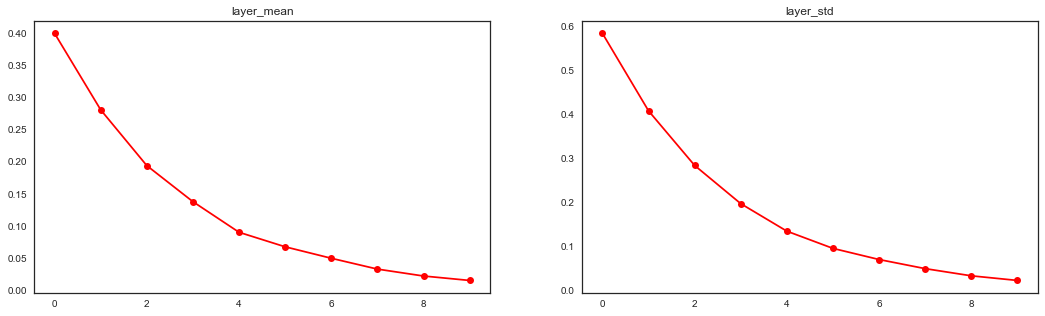

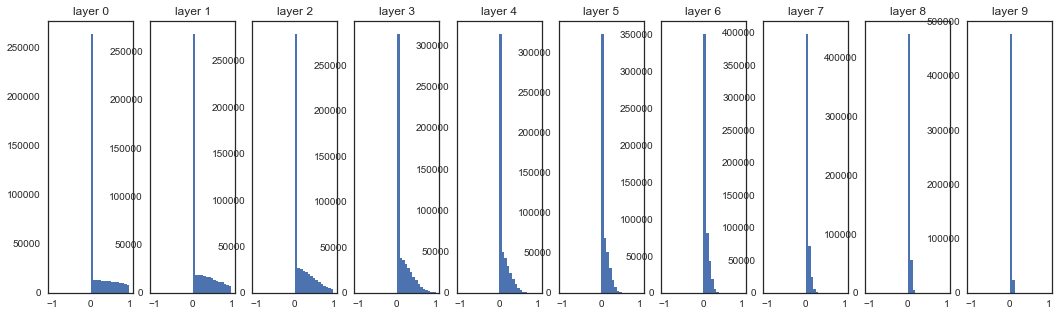

In [19]:
figure = layer_weights("relu", "Xavier")
figure.show()

However, as you can see Xavier does not work for the popular ReLu activation function, as the neuron's outputs start to become meaningless after 8 layers.

relu & He



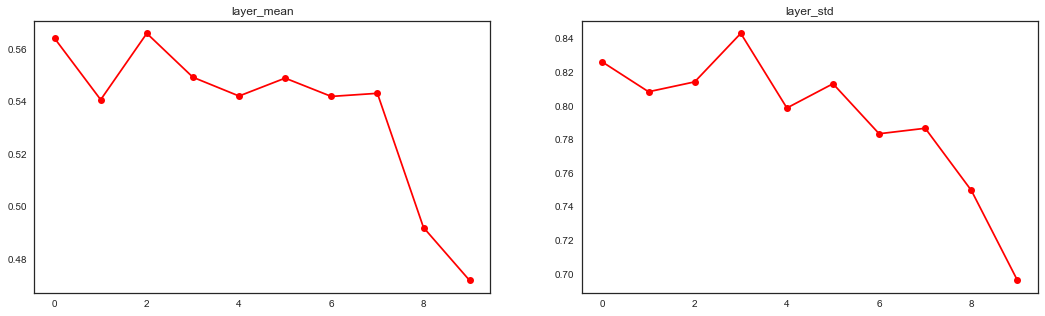

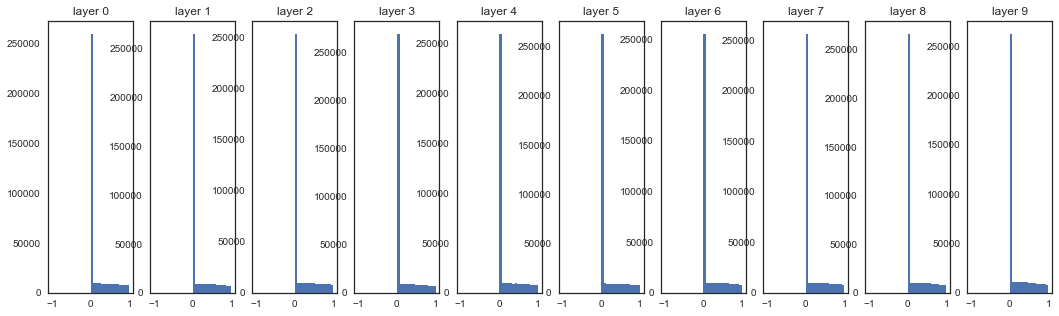

In [20]:
figure = layer_weights("relu", "He")
figure.show()

For the special case of ReLu neurons, [He et al., 2015](https://arxiv.org/pdf/1502.01852.pdf) proposed a modification of the Xavier initialization and as you can see above it works quite well (Note that this method also works well for sigmoid and tanh activations).

#### Pre-training

Besides randomly initializing the network parameters, one could also use a pre-training strategy. There are many different ways to pre-train deep neural networks. A very popular way is to use [shallow and well regularized autoencoders](https://www.coursera.org/learn/neural-networks/lecture/cxXuG/shallow-autoencoders-for-pre-training-7-mins). 

Moreover, sometimes researches have successfully trained similar network architectures on some other task such as [ImageNet](http://www.image-net.org/) or [GloVe](https://nlp.stanford.edu/projects/glove/) and published their network weights online. If these weights might be of use for the task at hand, one can use them to initialize and fine-tune a new model. 


#### Batch Normalization

Even though this topic not necessarily fits into "weight initialization", it recudes the issues associated with bad weight init schemes.

In order to improve the training of deep neural networks the [paper by Sergey Ioffe & Christian Szegedy](https://arxiv.org/abs/1502.03167) introduced a method called *Batch Normalization*. They propose to normalize layer inputs in order to reduce the effect of constantly shifting layer input distributions during training. Batch Normalization allows to use much higher learning rates and be less careful about weight initialization. It also sometimes acts as a regularizer (see section below).

Since Batch Normalization will not have a big effect in a two-layer neural network (where the data inputs are already normalized), I will not implement it in this notebook.

## Regularization

"*A central problem in machine learning is how to make an algorithm that will perform well not just on the training data, but also on new inputs. Many strategies used in machine learning are explicitly designed to reduce the test error, possibly at the expense of increased training error. These strategies are known collectively as regularization.*" ([Goodfellow et al 2016](http://www.deeplearningbook.org/contents/regularization.html)). In the following section I will introduce some of the most commonly used techniques to achieve a well regularized model. Usually, a combination of these approaches is applied when tackling some prediction problem in real-world cases.

### Weight decay

When performing weight decay regularization a weight constraint is added to the optimization procedure. This will effectively reduce the magnitude/values of parameters since higher value parameters are also associated with a higher loss (See below). Generally, there are two commonly used regularizers, namely L1 and L2 regularization. Both share the tunable hyperparameter $\lambda$ which controls for the strength of the regularization constraint. A larger value for $\lambda$ will increase bias whereas a smaller value will increase variance of the model.

#### L1 regularization

L1 uses the absolute value of the parameters (or L1-norm) and often leads to many zero weights (sparsity).

$J(\theta)_{regularized} = J(\theta) + \lambda \sum\limits_{j=1}^n |\theta_j|  = J(\theta) + \lambda \lVert \mathbf{\theta_j} \rVert_1$

$\frac{\partial J}{\partial \theta}_{regularized} = \frac{\partial J}{\partial \theta} + \lambda sign(\theta_j)$

#### L2 regularization

L2 uses the squared value of the parameters (or L2-norm) and is often more robust than L1.

$J(\theta)_{regularized} = J(\theta) + \lambda \sum\limits_{j=1}^n \theta_j^2  $

$\frac{\partial J}{\partial \theta}_{regularized} = \frac{\partial J}{\partial \theta_j} + 2\lambda \theta_j $

In [21]:
def L1_regularization(reg_lambda, W1, b1, W2, b2,mode="sum"):
    theta = np.concatenate((W1.flatten(), b1.flatten(),
        W2.flatten(), b2.flatten()))
    
    if mode == "mean":
        reg_cost = reg_lambda*np.average(np.absolute(theta))
    else:
        reg_cost = reg_lambda*np.linalg.norm(theta ,ord = 1)
    reg_grad = reg_lambda*np.sign(theta)
    return reg_cost, reg_grad

def L2_regularization(reg_lambda, W1, b1, W2, b2,mode="sum"):
    theta = np.concatenate((W1.flatten(), b1.flatten(),
        W2.flatten(), b2.flatten()))
    if mode == "mean":
        reg_cost = reg_lambda*np.average(np.power(theta,2))
    else:
        reg_cost = reg_lambda*np.sum(np.power(theta,2))
    reg_grad = reg_lambda*2*theta
    return reg_cost, reg_grad

### Early Stopping

In order to avoid overfitting one could also use a strategy called early stopping. A commonly used method is *Validation-based early stopping* where training is being stopped as soon as the error on the validation set starts increasing again. This method generalizes particularly well if k-fold cross-validation is used.

### Data augmentation

When dealing with image or video data, a popular method to achieve better generalization is *data augmentation*. Simply put, data augmentation alters each image slightly before using it for training. It does this through flipping, slightly changing hues, stretching, shearing, rotation, etc. However, it is important to use data augmentation in a sensible way and not vertically flip an image, for instance. An example of "augmented" cat images would look as follows:

![cat](http://wiki.fast.ai/images/c/c5/Data_aug.png)

### Dropout

[Dropout](https://arxiv.org/abs/1207.0580Dropout) is a technique proposed by Geoffrey Hinton for regularizing neural networks by randomly setting some features to zero during the forward pass. In the following code I will implement inverted dropout as suggested in the [Stanford CS231n class](http://cs231n.github.io/neural-networks-2/). In contrast to vanilla dropout where at test time one would have to scale activations by dropout rate p to match expected value at training, with inverted dropout, inverted scaling is applied at training time with scaling factor 1/p. Inverted dropout has the great advantages, that at test time, one does not need to worry about scaling and inference is usually faster.

In [22]:
def dropout_forward(x, p, mode, seed = None):
    """
    Performs the forward pass for (inverted) dropout.
    Inputs:
    - x: Input data, of any shape
    - dropout_params:
      - p: Dropout parameter. We drop each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.
    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    
    #initialize
    mask = None
    out = None

    if mode == 'train':
        # Store the dropout mask in the mask variable
        np.random.seed(seed)
        mask = (np.random.rand(*x.shape) < p) / p #Perform inverted dropout
        out = x * mask

    elif mode == 'test':
        mask = None
        out = x

    cache = ({"p":p,"mode":mode,"seed":seed}, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.
    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        dx = dout * mask

    elif mode == 'test':
        dx = dout
    return dx

## Gradient checking

In order to validate the implementation of my analytic gradients above I will  check them with an approximate calculation of the numerical gradients.

$\frac{\partial J}{\partial x_0} \approx \frac{J(x_0+h)-J(x_0-h)}{2h}\quad\\
\quad \\
\text{where} \quad J \quad \text{is the cost function,}\quad x_0 \quad \text{a parameter to check the gradient at and}\quad h \quad \text{is a small number close to zero.}$

In [23]:
def gradcheck_naive(f, x):
    """ Gradient check for a function f.

    Arguments:
    f -- a function that takes a single argument and outputs the
         cost and its gradients
    x -- the point (numpy array) to check the gradient at
    """

    rndstate = random.getstate()
    random.setstate(rndstate)
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4        

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        # Modifying a single parameter with h defined above to compute
        # numerical gradients.
        
        x2 = x.copy()
        x2[ix] = x2[ix]+h 
        random.setstate(rndstate)
        fxh1,_ = f(x2)
        
        random.setstate(rndstate)
        x2 = x.copy()
        x2[ix] = x2[ix]-h 
        fxh2,_ = f(x2)
        numgrad = (fxh1-fxh2)/(2*h)

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print "Gradient check failed."
            print "First gradient error found at index %s" % str(ix)
            print "Your gradient: %f \t Numerical gradient: %f" % (
                grad[ix], numgrad)
            return

        it.iternext() # Step to next dimension

    print "Gradient check passed! The implementation is correct."

In [24]:
def sanity_check():
    """
    Set up fake data and parameters for the neural network, and test using
    gradcheck.
    """
    print "Running sanity check..."

    N = 20
    dimensions = [10, 5, 10]
    data = np.random.randn(N, dimensions[0])   # each row will be a datum
    labels = np.zeros((N, dimensions[2]))
    for i in xrange(N):
        labels[i,random.randint(0,dimensions[2]-1)] = 1
               
    #Initialize parameters/weights randomly
    params = init_weights(dimensions)
    
    gradcheck_naive(lambda params: loss(data, params,dimensions, labels,weight_decay = L2_regularization,
                                        dropout = True,seed = 0), params)

In [25]:
sanity_check()

Running sanity check...
Gradient check passed! The implementation is correct.


## Gradient Descent

*"Gradient descent is an iterative optimization algorithm for finding the minimum of a cost function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the [first-order] gradient of the function at the current point"* ([Wikipedia](https://en.wikipedia.org/wiki/Gradient_descent)). More precisely, in each step we will slightly update the weights of our network towards a lower loss value. The step size for each update is determined by the learning rate, which is one of the many hyperparameters of a neural network and all following optimizers have it in common.

The overall goal in the following is: $\displaystyle \min_{\theta} J(\theta)$

### Optimizer

In order to adjust the weights of the network we need to decide how we want to use the first-order gradient signal to perform the weight update. Besides the very basic gradient descent update, many other optimizers have been proposed by researchers. As you can see in the following animation the more "advanced" optimizers are quite promising as they seem to lead to faster convergence towards a local minimum (star spot in the middle). 

<img src="http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s1600/s25RsOr%2B-%2BImgur.gif">

#### Basic Stochastic Gradient Descent

The basic stochastic gradient descent update is fairly simple and only uses the first-order gradients, which are being weighted by a pre-determined learning rate. To train large and deep neural networks SGD is an inappropriate choice due to its slow convergence (or too fast updates if the learning rate is set too high and local minima being "overshot").

In [26]:
def sgd(x, dx, config=None):
    """
    Performs basic stochastic gradient descent.
    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
        
    #Set default values for first update
    config.setdefault('learning_rate', 1e-2) # tunable parameter

    x -= config['learning_rate'] * dx
    return x, config

#### SGD with Momentum

In order to improve SGD it was proposed to take a moving average of all previous gradient values into account when performing the weight update. This leads to an effect where weight updates are large when gradient values are high or when we are far from a local minimum (We move faster towards a local minimum). As we approach a local minimum gradient values decrease and hence, weight updates get increasingly smaller (we move slower towards a local minimum).

However, as we can see in the animation above, SGD with momentum has a risk to overshoot local optima initially. This is usually something one would want to avoid in order to achieve fast convergence during training. Therefore, this optimizer is rarely used in applications today.

In [27]:
def sgd_momentum(x, dx, config=None):
    """
    Performs stochastic gradient descent with momentum.
    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value. (Momentum = 0 = SGD)
    - velocity: A numpy array of the same shape as x and dx used to store a moving
      average of the gradients.
    """

    if config is None:
        config = {}
        
    #Set default values for first update
    config.setdefault('learning_rate', 1e-2) #tunable parameter
    config.setdefault('momentum', 0.9) #tunable parameter
    
    v = config.get('velocity', np.zeros_like(dx))
    
    # Calculate velocity
    next_v = config['momentum'] * v - config['learning_rate'] * dx
    
    #Perform weight update using updated velocity
    next_x = x + next_v
    
    # Update Velocity in config
    config['velocity'] = next_v

    return next_x, config

#### Adagrad

Adagrad improves upon SGD with momentum in the sense that it adapts the learning rate for **each parameter** individually by dividing by the square root of the average of the previous gradients.

In [28]:
def adagrad(x, dx, config=None):
    """
    Uses the Adagrad update rule, which uses squared gradient
    values to set adaptive per-parameter learning rates.
    
    config format:
    - learning_rate: Scalar learning rate.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Squared gradient values.
    """

    if config is None:
        config = {}
        
    #Set default values for first update
    config.setdefault('learning_rate', 1e-2) #tunable parameter
    config.setdefault('epsilon', 1e-8) #tunable parameter
    
    config.setdefault('cache', np.zeros_like(x))
    
    #Calculate cache
    config['cache'] = config['cache'] + dx**2
    
    #Calculate parameter update
    next_x = x - config['learning_rate'] * dx / (np.sqrt(config['cache']
                                                         + config['epsilon']))

    return next_x, config

#### Rmsprop

RMSprop proposed by Geoffrey Hinton in its online course on Neural Networks on [Coursera](https://www.coursera.org/learn/neural-networks) is very similar to Adagrad. It also adapts the learning rate for **each parameter** individually, but uses a exponentially decaying average of squared gradients. Both Adagrad and Rmsprop are popular because of their fast and robust convergence. 

In [29]:
def rmsprop(x, dx, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared gradient
    values to set adaptive per-parameter learning rates.
    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """

    if config is None:
        config = {}
        
    #Set default values for first update
    config.setdefault('learning_rate', 1e-2) #tunable parameter
    config.setdefault('decay_rate', 0.99) #tunable parameter
    config.setdefault('epsilon', 1e-8) #tunable parameter
    
    config.setdefault('cache', np.zeros_like(x))
    
    #Calculate cache
    config['cache'] = config['cache'] * config['decay_rate'] + (1 - config['decay_rate']) * dx**2
    
    #Calculate parameter update
    next_x = x - config['learning_rate'] * dx / (np.sqrt(config['cache']
                                                         + config['epsilon']))

    return next_x, config

#### Adam

The probably most commonly used optimizer is currently Adam. It is a little more complicated than the other optimizers but can be thought of as a mixture between rmsprop and momentum.

In [30]:
def adam(x, dx, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term. (or: RMSprop with momentum)
    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient. (Momentum)
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None:
        config = {}
        
    #Set default values for first update
    config.setdefault('learning_rate', 1e-3) #tunable parameter
    config.setdefault('beta1', 0.9) #tunable parameter
    config.setdefault('beta2', 0.999) #tunable parameter
    config.setdefault('epsilon', 1e-8) #tunable parameter
    
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 0)
    
    #Assign parameter to variables for convenience
    learning_rate = config['learning_rate']
    beta1 = config['beta1']
    beta2 = config['beta2']
    epsilon = config['epsilon']
    
    # Calculate "cache" values for adam
    config['t'] += 1
    config['m'] = beta1 * config['m'] + (1 - beta1) * dx
    config['v'] = beta2 * config['v'] + (1 - beta2) * dx**2
    
    # Calculate parameter update
    mt_hat = config['m'] / (1 - (beta1)**config['t'])
    vt_hat = config['v'] / (1 - (beta2)**config['t'])
    next_x = x - learning_rate * mt_hat / (np.sqrt(vt_hat + epsilon))

    return next_x, config

### Solver for training

In order to run the gradient descent algorithm, I define a wrapper, which performs "learning" for a given number of iterations and lets one choose between different activation functions for the hidden layers, optimizers and regularizers.

In [31]:
def check_accuracy(X, y, params, dimensions, act_func, weight_decay = None,reg_lambda=0.001):
        """
        Check accuracy of the model on the provided data.
        Inputs:
        - X: Array of data
        - y: Array of labels
        - params: the network weights
        - dimensions: the network architecture
        - act_func: the activation function for the hidden layer.
        - batch_size: Split X and y into batches of this size to avoid using too
          much memory.
        Returns:
        - cost: cross-entropy loss
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """
        N = X.shape[0]
            
        # perform forward pass
        scores,W1, b1, W2, b2 = loss(X,params,dimensions,act_func = act_func,mode="test")
        y_pred = np.argmax(scores, axis=1)
        
        # Compute normalized cross entropy loss with or without regularization
        cost = -np.average((y * np.log(scores)).sum(axis=1))
        acc = np.mean(y_pred == np.argmax(y, axis=1))
        
        if weight_decay:
            reg_cost, _ = weight_decay(reg_lambda, W1, b1, W2, b2,mode="mean")
            return cost + reg_cost, acc
        
        return cost,acc

In [32]:
def shuffle_data(X,y):
    # Generate the permutation index array.
    permutation = np.random.permutation(X.shape[0])
    
    # Shuffle the arrays by giving the permutation in the square brackets.
    X = X[permutation]
    y = y[permutation]

    return X,y

def step(X_batch,y_batch, params, dimensions, act_func,
         optim = adam, optim_config = None,
         weight_decay = None,reg_lambda=0.001, dropout = False, p = 0.5):
    
        """
        Make a single gradient update. This is called by train().
        """
        
        # Make a minibatch of training data
        #num_train = X_train.shape[0]
        #batch_mask = np.random.choice(num_train, batch_size)
        #X_batch = X_train[batch_mask]
        #y_batch = y_train[batch_mask]
        
        # Compute loss and gradient
        cost, grads = loss(X_batch, params, dimensions, labels = y_batch, act_func = act_func,
                           weight_decay = weight_decay,reg_lambda=reg_lambda,dropout = dropout, p = p)
        
        # Perform a parameter update
        next_w, next_config = optim(params, grads, optim_config)
        
        return cost, next_w, next_config
    
            
def train(X_train,y_train, X_val,y_val,
         params, dimensions, act_func="relu",
         num_epochs = 10,batch_size = 100, 
         optim = adam, optim_config = None, lr_decay = 0.95,shuffle = True,
         weight_decay = None,reg_lambda=0.001,dropout = False, p = 0.5):
    
        """
        Run optimization to train the model.

        Inputs:
            - data:
              'X_train': Array giving training data
              'y_train': Array giving labels for training data
              'X_val': Array giving validation data
              'y_val': Array giving labels for validation data
            - params: the network weights
            - dimensions: the network architecture
            - act_func: the activation function for the hidden layer. Default is "ReLu"
            - num_epochs: Number of passes through the training set
            - batch_size: Batchsize for each param update
            - optim: A function object giving an update rule.
              Default is 'adam'.
            - optim_config: A dictionary containing hyperparameters that will be
              passed to the chosen update rule. Each update rule requires different
              hyperparameters but all update rules require a
              'learning_rate' parameter so that should always be present.
            - lr_decay: A scalar for learning rate decay; after each epoch the learning
              rate is multiplied by this value.
            - shuffle: Boolean determining whether or not to shuffle the training data during training.
            - weight_decay: A function object determining the weight decay scheme.
            - reg_lambda: Hyperparameter for performing weight decay
            - dropout: Boolean whether to perform dropout
            - p: Dropout probability.
        Outputs:
            - out: Array of the same shape as x.
            - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
              mask that was used to multiply the input; in test mode, mask is None.
        """
        
        num_train = X_train.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)
        num_iterations = num_epochs * iterations_per_epoch
        
        loss_history = []
        val_loss_history = []
        epoch = 0
   
        for t in xrange(num_epochs):
            
            # Randomize data points
            if shuffle: 
                X_train, y_train = shuffle_data(X_train, y_train)
            
            # Before every epoch print loss and accuracy for full training data & validation data
            
            # Perform batch gradient update
            for i in range(0, X_train.shape[0], batch_size):
                # Get pair of (X, y) of the current batch_size
                X_train_mini = X_train[i:i + batch_size]
                y_train_mini = y_train[i:i + batch_size]
                
                cost, params, optim_config = step(X_train_mini,y_train_mini,
                                                  params, dimensions, act_func, optim, optim_config,
                                                  weight_decay = weight_decay,reg_lambda=reg_lambda,dropout = dropout, p = p)    
                
            # After every epoch print loss and accuracy for full training data & validation data
            # Check train accuracy & loss
            full_loss,acc = check_accuracy(X_train, y_train, params, dimensions, act_func,
                                           weight_decay = weight_decay,reg_lambda=reg_lambda)
            loss_history.append(full_loss)

            #Check val acc & loss
            val_full_loss,val_acc = check_accuracy(X_val, y_val, params, dimensions, act_func,
                                                   weight_decay = weight_decay,reg_lambda=reg_lambda)
            val_loss_history.append(val_full_loss)

            print '(Epoch %d / %d) train_loss: %f , train_acc: %f -- val_loss: %f , val_acc: %f' % (
                t+1, num_epochs, full_loss,acc,val_full_loss,val_acc)
            
            # At the end of every epoch, decay the learning rate.
            optim_config['learning_rate'] *= lr_decay
                
        return loss_history,val_loss_history,params

## Putting it all together & run it

The network will consist of one hidden layer with 256 ($2^8$) units. The number of hidden units has been chosen to be a number to the power of two since this is a convention which has developed regarding network architectures. 

In [33]:
# Set network dimensions and activation for hidden layer
dimensions = (n_features,2**8,n_classes) # (Dx, H, Dy)
activation = "relu"

In [34]:
# Initialize parameters
init_params = init_weights(dimensions,scheme = "He",seed = rnd_state)

In [35]:
check_accuracy(X_resampled, y_resampled, init_params, dimensions, act_func=activation)[1]

0.33333333333333331

After having randomly initialized the network parameters, the model is achieving a accuracy on the training data, which is as good as random guessing (given that 33% of the training data belongs to class 1).

In [55]:
# Train network using training data

loss_history,val_loss_history,trained_weights = train(X_resampled, y_resampled,X_val,y_val,
                                                      init_params, dimensions, act_func=activation,
                                                      num_epochs = 150,batch_size = 2**10, 
                                                      optim = adam, optim_config = {"learning_rate":0.01}, 
                                                      lr_decay = 1.,shuffle = True,
                                                      weight_decay = L2_regularization,reg_lambda=0.5,
                                                      dropout = True, p = 0.5)

Training with no regularization


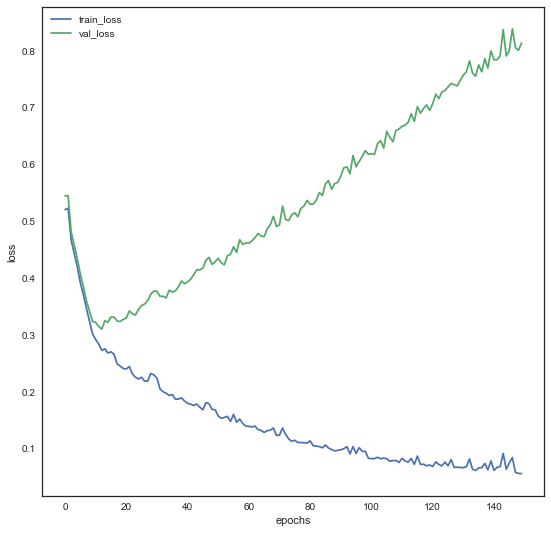

In [37]:
print "Training with no regularization"
plt.figure(figsize=(9,9))
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.legend(["train_loss","val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Training the network for 150 epochs without any regularization results in a model which is highly overfitting the data at hand. This becomes fairly obvious when analyzing the loss curves on the training and validation data above. This is a perfect starting point from where we can now introduce some regularization.

Training with weight decay


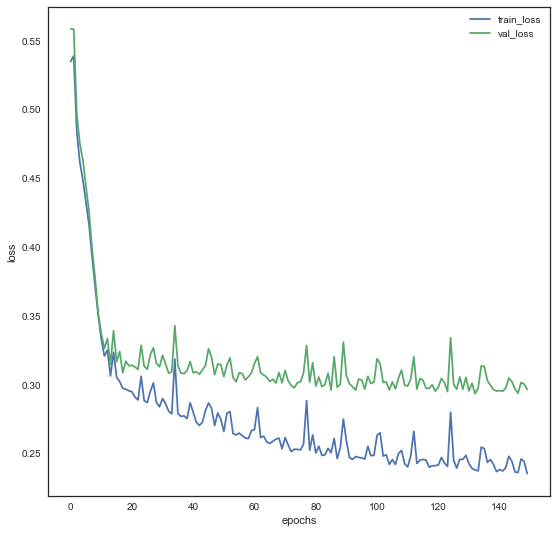

In [39]:
print "Training with weight decay"
plt.figure(figsize=(9,9))
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.legend(["train_loss","val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

When using L2 weight decay with a *lambda* of 0.5, we instantly see that the model is capable of generalizing much better. The validation and training curves are converging between a cross-entropy loss of 0.2 and 0.35.

Training with dropout


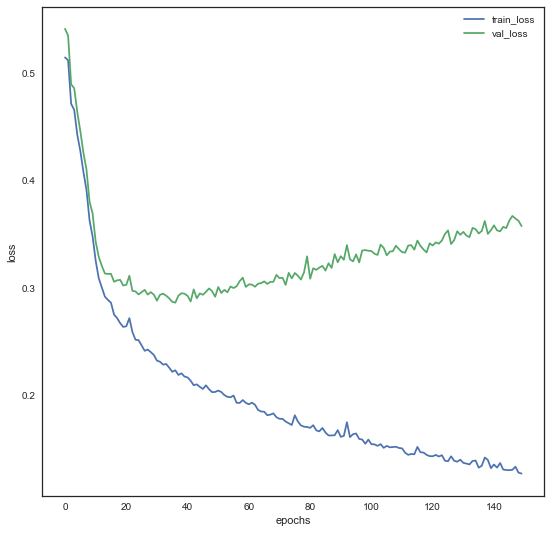

In [41]:
print "Training with dropout"
plt.figure(figsize=(9,9))
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.legend(["train_loss","val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Similar generalization can be achieved when using dropout with a *probability* of 0.5 after the hidden layer of the network. 

Training with weight decay and dropout


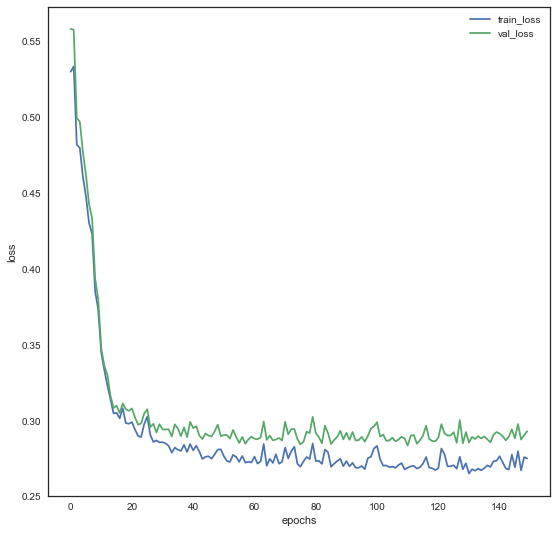

In [43]:
print "Training with weight decay and dropout"
plt.figure(figsize=(9,9))
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.legend(["train_loss","val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Even though, the network is still slightly overfitting the data, the best regularization is achieved when using both L2 (lambda = 0.5) and Dropout (p = 0.5). This is as expected and suggests that usually one would want use mutiple regularization techniques when tackling a machine learning problem.

In [47]:
from utils import *
from plot_evaluation import *

preds,_,_,_,_ = loss(X_test,trained_weights,dimensions,act_func = activation,mode="test")

precision, recall, f1, acc = evaluate(y_test.argmax(axis=1),preds.argmax(axis=1),pos_label = 1)
print "Final performance evaluation metrics"
print
print "precision for class 1: ",precision
print "recall for class 1: ",recall
print "f1 score for class 1: ",f1
print "accuracy: ",acc

Final performance evaluation metrics

precision for class 1:  0.50136239782
recall for class 1:  0.793103448276
f1 score for class 1:  0.614357262104
accuracy:  0.887836853605


Confusion matrix, without normalization


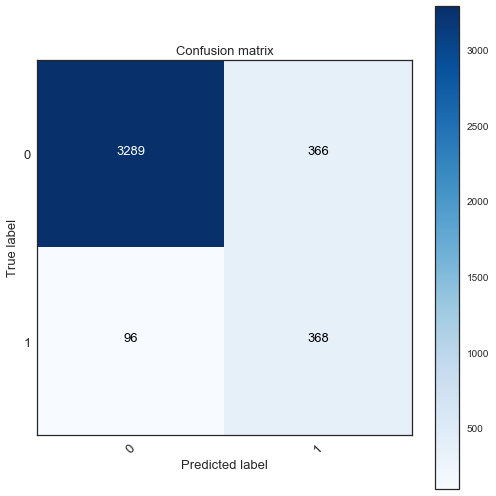

In [48]:
plt = plot_confusion_matrix(y_test, preds, [0,1], normalize = False,figsize = (7,7),fontsize=13)
plt.show()

Finally, the model which was trained to recognize patterns associated with positive class customers is achieving a good f1-score of 61% on class 1. This is not a perfect classifier but already quite good considering the fact that a fairly simple model with no hyperparameter tuning (using [Randomized Gridsearch](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) or advanced optimization schemes such as [Bayesian optimization over hyper parameters](http://steventhornton.ca/hyperparameter-tuning-with-hyperopt-in-python/)) was trained.

In [54]:
# Train network using multiple optimizers training data
rnd_state = 73

histories = {}
val_histories = {}
for optimizer in ["sgd","sgd_momentum","adagrad","rmsprop","adam"]:
    print optimizer
    # Initialize parameters
    init_params = init_weights(dimensions,scheme = "He",seed = rnd_state)
    
    loss_history,val_loss_history,trained_weights = train(X_resampled, y_resampled,X_val,y_val,
                                                          init_params, dimensions, act_func=activation,
                                                          num_epochs = 150,batch_size = 2**10, 
                                                          optim = globals()[optimizer], optim_config = {"learning_rate":0.001},
                                                          lr_decay = 1.0,shuffle = True)
    histories[optimizer] = loss_history
    val_histories[optimizer] = val_loss_history

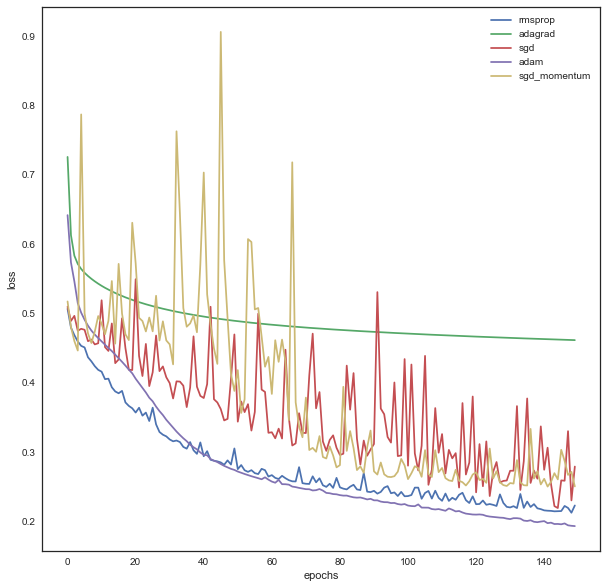

In [52]:
leg = []
plt.figure(figsize=(10,10))
for key in histories:
    plt.plot(histories[key],label = key)
    leg.append(key)
plt.legend(leg)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Finally, I compared the convergence of different optimizers on my data set and random weight initialization. It turns out that I can confirm that the "more advanced" optimizers are converging much faster than basic SGD. Especially, the adam and rmsprop optimizer are converging the fastest and seem to be much more robust (less volatile in the loss) than all other optimizers.

# Conclusion & Thank you

Making this notebook was a valuable learning experience for me. I went from having a general understanding of neural networks to being able to write one entirely from scratch.

Am I going to consistently build standard networks from scratch? Absolutely not. But, without the foundation I developed from preparing for this notebook, I would have a much more difficult time trying to debug deep and more complex networks such as RNNs or CNNs.

Thanks to the authors of the following online resources I was able to learn a lot about neural networks and successfully apply deep learning as well as machine learning in general to real world problems in [my projects](https://github.com/bockjo) or on [kaggle](https://www.kaggle.com/bockjo):

* [Stanford's CS231n Convolutional Neural Networks for Visual Recognition by Andrej Karpathy](http://cs231n.stanford.edu/2016/syllabus)
* [Stanford's Machine Learning by Andrew Ng](https://www.coursera.org/learn/machine-learning)
* [Neural Networks for Machine Learning by Geoffrey Hinton](https://www.coursera.org/learn/neural-networks)
* [Deep Learning for Coders by Jeremy Howard](http://course.fast.ai/)
* [Deep Learning by Ian Goodfellow and Yoshua Bengio](http://www.deeplearningbook.org/)

- 